In [1]:
#ENVIRONMENT SETUP

In [2]:
!pip install wordcloud
import re
import pickle
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [4]:
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nbuna\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [35]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nbuna\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
#LOADING THE DATASET

DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv(r'C:\Users\nbuna\Downloads\Project_Dataset.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

Text(0.5, 1.0, 'Sentiment Frequency Distribution')

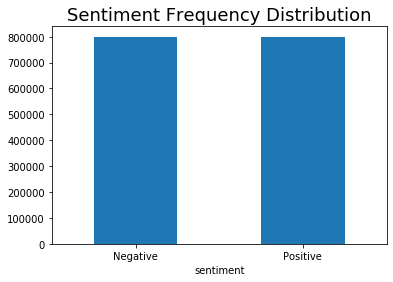

In [8]:
#plotting distribution of dependent values i.e. sentiment 

ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(dataset['text']), list(dataset['sentiment'])
plt.title('Sentiment Frequency Distribution', fontsize=18)

In [9]:
#Data Exploration, counting hashtags 
dataset.text.str.extractall(r'(\#\w+)')[0].value_counts()

#followfriday    2114
#fb              1747
#squarespace      888
#FF               586
#1                519
                 ... 
#processwork        1
#Tethering          1
#wikibon            1
#MGS                1
#182                1
Name: 0, Length: 13653, dtype: int64

In [10]:
dataset.text.str.extractall(r'(\@\w+)')[0].count()

786609

In [11]:
dataset.text.str.extractall(r'([A-ZA-Z]+)')[0].value_counts()

I               767990
T               238820
S               219683
M               186229
A               166195
                 ...  
NEGROOOO             1
ASTA                 1
JAMESONWELLS         1
OSCP                 1
NWB                  1
Name: 0, Length: 45136, dtype: int64

In [12]:
#Descriptive stats: readability and richness

In [13]:
!pip install textstat
from textstat.textstat import textstat

In [14]:
# all text in one string BEFORE clean up 
lumpedtest= ' '. join(text)

In [15]:
#lexicon count BEFORE clean up 
textstat.lexicon_count(lumpedtest)

20859449

In [16]:
#Reading ease BEFORE clean up 
textstat.flesch_reading_ease(lumpedtest)

54.39

In [17]:
#dataset = dataset[['sentiment','text']]
df=dataset[['sentiment', 'text']]
df['word_count']=df['text']. apply (lambda x:len(str(x).split()))
df['tweet_len']= df['text'].astype(str).apply(len)

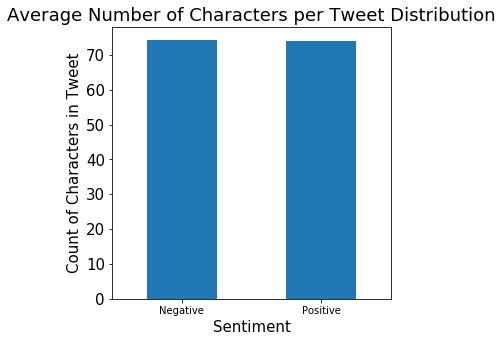

In [18]:
#Average Number of Characters per Tweet Distribution
tweet_average=df.groupby('sentiment')['tweet_len'].mean().plot(kind='bar', figsize=(5,5))
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Count of Characters in Tweet', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Average Number of Characters per Tweet Distribution', fontsize=18)
tweet_average.set_xticklabels(['Negative','Positive'], rotation=0, fontsize=10)
plt.show()

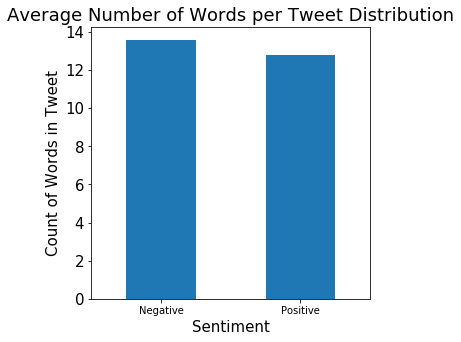

In [19]:
#Average Number of Words per Tweet Distribution
tweet_average_words=df.groupby('sentiment')['word_count'].mean().plot(kind='bar', figsize=(5,5))
plt.xlabel('Sentiment', fontsize=15)
plt.ylabel('Count of Words in Tweet', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Average Number of Words per Tweet Distribution', fontsize=18)
tweet_average_words.set_xticklabels(['Negative','Positive'], rotation=0, fontsize=10)
plt.show()

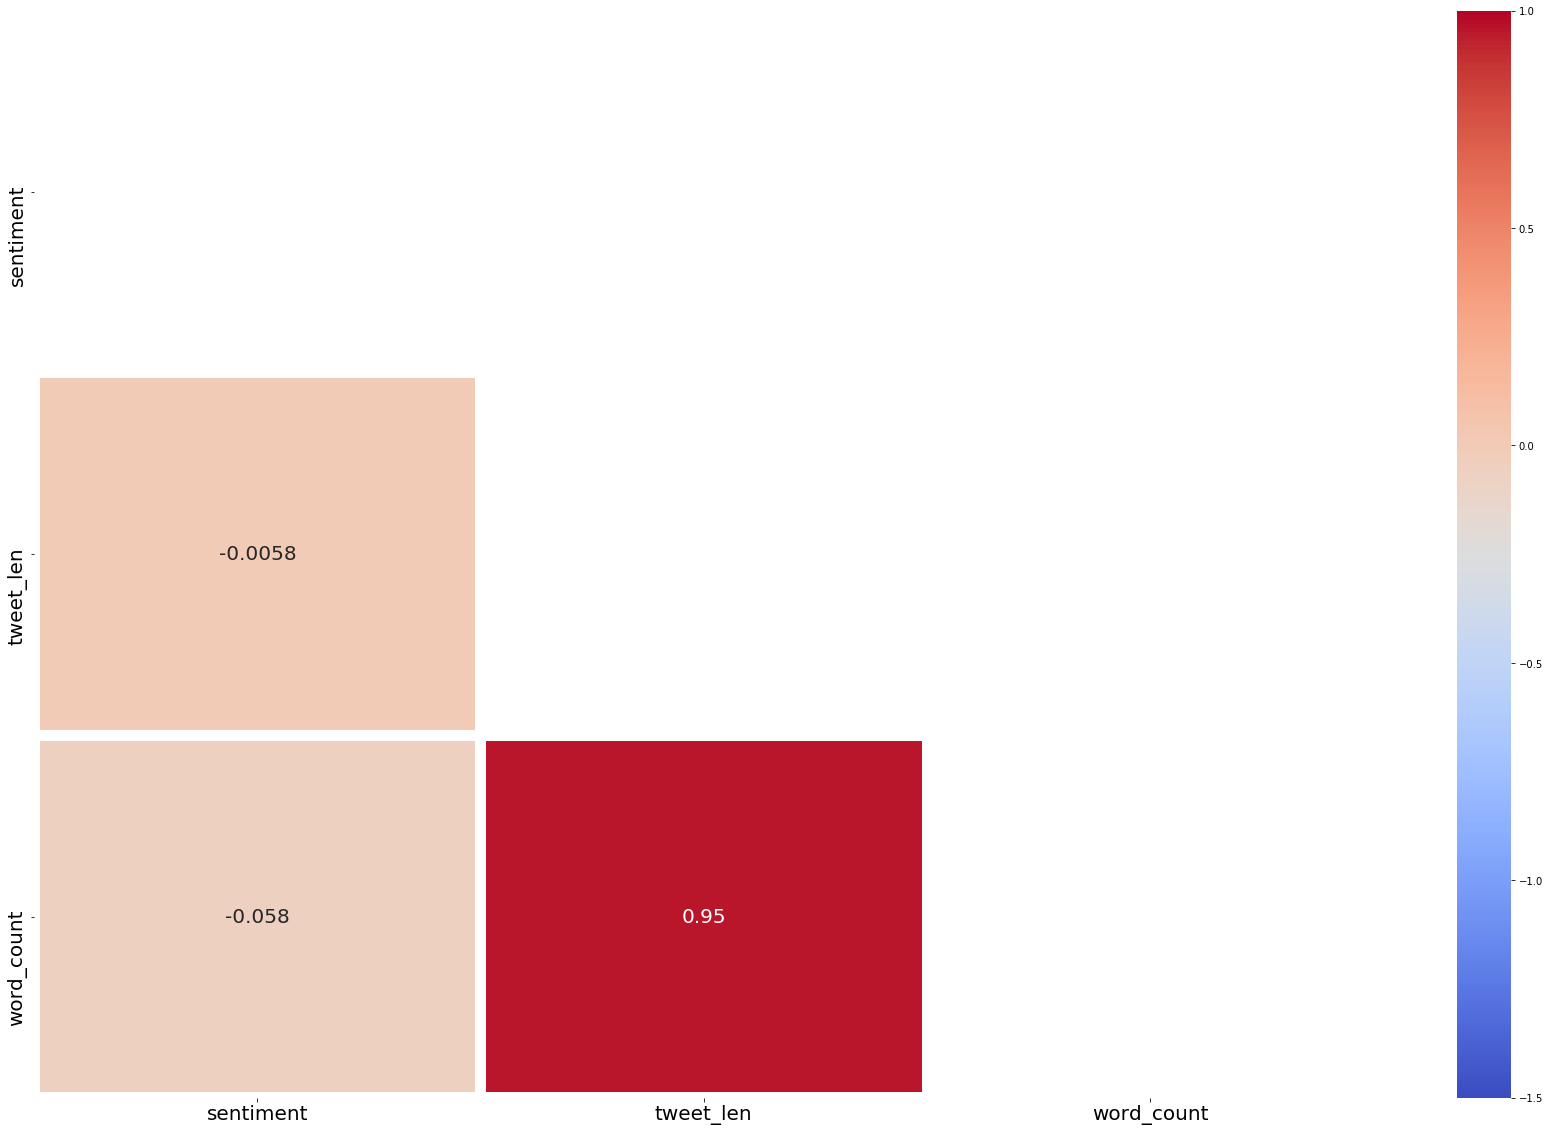

In [20]:
correlation = df[['text','sentiment', 'tweet_len', 'word_count']].corr()
mask = np.zeros_like(correlation, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(30,20))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
sns.heatmap(correlation, cmap='coolwarm', annot=True, annot_kws={"size":20}, linewidths=10, vmin=-1.5, mask=mask)

In [ ]:
#NLP PREPROCESSING

In [28]:
stopwordslist= ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves', "USER", "URL"]

In [25]:
#defining stopwords

stopwordslist=["0o", "0s", "3a", "3b", "3d", "6b", "6o", "a", "a1", "a2", "a3", "a4", "ab", "able", 
               "about", "above", "abst", "ac", "accordance", "according", "accordingly", "across", 
               "act", "actually", "ad", "added", "adj", "ae", "af", "affected", "affecting", 
               "affects", "after", "afterwards", "ag", "again", "against", "ah", "ain", "ain't", 
               "aj", "al", "all", "allow", "allows", "almost", "alone", "along", "already", "also", 
               "although", "always", "am", "among", "amongst", "amoungst", "amount", "an", "and", 
               "announce", "another", "any", "anybody", "anyhow", "anymore", "anyone", "anything", 
               "anyway", "anyways", "anywhere", "ao", "ap", "apart", "apparently", "appear", 
               "appreciate", "appropriate", "approximately", "ar", "are", "aren", "arent", "aren't", 
               "arise", "around", "as", "a's", "aside", "ask", "asking", "associated", "at", "au", 
               "auth", "av", "available", "aw", "away", "awfully", "ax", "ay", "az", "b", "b1", 
               "b2", "b3", "ba", "back", "bc", "bd", "be", "became", "because", "become", "becomes", 
               "becoming", "been", "before", "beforehand", "begin", "beginning", "beginnings",
               "begins", "behind", "being", "believe", "below", "beside", "besides", "best", "better", 
               "between", "beyond", "bi", "bill", "biol", "bj", "bk", "bl", "bn", "both", "bottom", 
               "bp", "br", "brief", "briefly", "bs", "bt", "bu", "but", "bx", "by", "c", "c1", "c2", 
               "c3", "ca", "call", "came", "can", "cannot", "cant", "can't", "cause", "causes", "cc",
               "cd", "ce", "certain", "certainly", "cf", "cg", "ch", "changes", "ci", "cit", "cj", 
               "cl", "clearly", "cm", "c'mon", "cn", "co", "com", "come", "comes", "con", "concerning",
               "consequently", "consider", "considering", "contain", "containing", "contains", 
               "corresponding", "could", "couldn", "couldnt", "couldn't", "course", "cp", "cq", "cr",
               "cry", "cs", "c's", "ct", "cu", "currently", "cv", "cx", "cy", "cz", "d", "d2", "da", 
               "date", "dc", "dd", "de", "definitely", "describe", "described", "despite", "detail", 
               "df", "di", "did", "didn", "didn't", "different", "dj", "dk", "dl", "do", "does", 
               "doesn", "doesn't", "doing", "don", "done", "don't", "down", "downwards", "dp", "dr", 
               "ds", "dt", "du", "due", "during", "dx", "dy", "e", "e2", "e3", "ea", "each", "ec",
               "ed", "edu", "ee", "ef", "effect", "eg", "ei", "eight", "eighty", "either", "ej", "el",
               "eleven", "else", "elsewhere", "em", "empty", "en", "end", "ending", "enough", 
               "entirely", "eo", "ep", "eq", "er", "es", "especially", "est", "et", "et-al", "etc", 
               "eu", "ev", "even", "ever", "every", "everybody", "everyone", "everything", "everywhere",
               "ex", "exactly", "example", "except", "ey", "f", "f2", "fa", "far", "fc", "few", "ff", 
               "fi", "fifteen", "fifth", "fify", "fill", "find", "fire", "first", "five", "fix", "fj",
               "fl", "fn", "fo", "followed", "following", "follows", "for", "former", "formerly",
               "forth", "forty", "found", "four", "fr", "from", "front", "fs", "ft", "fu", "full", 
               "further", "furthermore", "fy", "g", "ga", "gave", "ge", "get", "gets", "getting", 
               "gi", "give", "given", "gives", "giving", "gj", "gl", "go", "goes", "going", "gone", 
               "got", "gotten", "gr", "greetings", "gs", "gy", "h", "h2", "h3", "had", "hadn", "hadn't", 
               "happens", "hardly", "has", "hasn", "hasnt", "hasn't", "have", "haven", "haven't", 
               "having", "he", "hed", "he'd", "he'll", "hello", "help", "hence", "her", "here",
               "hereafter", "hereby", "herein", "heres", "here's", "hereupon", "hers", "herself",
               "hes", "he's", "hh", "hi", "hid", "him", "himself", "his", "hither", "hj", "ho", "home",
               "hopefully", "how", "howbeit", "however", "how's", "hr", "hs", "http", "hu", "hundred", 
               "hy", "i", "i2", "i3", "i4", "i6", "i7", "i8", "ia", "ib", "ibid", "ic", "id", "i'd", "ie", 
               "if", "ig", "ignored", "ih", "ii", "ij", "il", "i'll", "im", "i'm", "immediate", 
               "immediately", "importance", "important", "in", "inasmuch", "inc", "indeed", "index", 
               "indicate", "indicated", "indicates", "information", "inner", "insofar", "instead", 
               "interest", "into", "invention", "inward", "io", "ip", "iq", "ir", "is", "isn", "isn't", 
               "it", "itd", "it'd", "it'll", "its", "it's", "itself", "iv", "i've", "ix", "iy", "iz", "j", 
               "jj", "jr", "js", "jt", "ju", "just", "k", "ke", "keep", "keeps", "kept", "kg", "kj", 
               "km", "know", "known", "knows", "ko", "l", "l2", "la", "largely", "last", "lately", "later",
               "latter", "latterly", "lb", "lc", "le", "least", "les", "less", "lest", "let", "lets", 
               "let's", "lf", "like", "liked", "likely", "line", "little", "lj", "ll", "ll", "ln", "lo", 
               "look", "looking", "looks", "los", "lr", "ls", "lt", "ltd", "m", "m2", "ma", "made", 
               "mainly", "make", "makes", "many", "may", "maybe", "me", "mean", "means", "meantime", 
               "meanwhile", "merely", "mg", "might", "mightn", "mightn't", "mill", "million", "mine", 
               "miss", "ml", "mn", "mo", "more", "moreover", "most", "mostly", "move", "mr", "mrs", "ms", 
               "mt", "mu", "much", "mug", "must", "mustn", "mustn't", "my", "myself", "n", "n2", "na", 
               "name", "namely", "nay", "nc", "nd", "ne", "near", "nearly", "necessarily", "necessary", 
               "need", "needn", "needn't", "needs", "neither", "never", "nevertheless", "new", "next", 
               "ng", "ni", "nine", "ninety", "nj", "nl", "nn", "no", "nobody", "non", "none", "nonetheless", 
               "noone", "nor", "normally", "nos", "not", "noted", "nothing", "novel", "now", "nowhere", "nr", 
               "ns", "nt", "ny", "o", "oa", "ob", "obtain", "obtained", "obviously", "oc", "od", "of", "off", 
               "often", "og", "oh", "oi", "oj", "ok", "okay", "ol", "old", "om", "omitted", "on", "once", 
               "one", "ones", "only", "onto", "oo", "op", "oq", "or", "ord", "os", "ot", "other", "others", 
               "otherwise", "ou", "ought", "our", "ours", "ourselves", "out", "outside", "over", "overall",
               "ow", "owing", "own", "ox", "oz", "p", "p1", "p2", "p3", "page", "pagecount", "pages", "par",
               "part", "particular", "particularly", "pas", "past", "pc", "pd", "pe", "per", "perhaps", "pf", 
               "ph", "pi", "pj", "pk", "pl", "placed", "please", "plus", "pm", "pn", "po", "poorly", 
               "possible", "possibly", "potentially", "pp", "pq", "pr", "predominantly", "present", 
               "presumably", "previously", "primarily", "probably", "promptly", "proud", "provides", 
               "ps", "pt", "pu", "put", "py", "q", "qj", "qu", "que", "quickly", "quite", "qv", "r", 
               "r2", "ra", "ran", "rather", "rc", "rd", "re", "readily", "really", "reasonably", "recent",
               "recently", "ref", "refs", "regarding", "regardless", "regards", "related", "relatively",
               "research", "research-articl", "respectively", "resulted", "resulting", "results", "rf", 
               "rh", "ri", "right", "rj", "rl", "rm", "rn", "ro", "rq", "rr", "rs", "rt", "ru", "run", 
               "rv", "ry", "s", "s2", "sa", "said", "same", "saw", "say", "saying", "says", "sc", "sd", 
               "se", "sec", "second", "secondly", "section", "see", "seeing", "seem", "seemed", "seeming", 
               "seems", "seen", "self", "selves", "sensible", "sent", "serious", "seriously", "seven", 
               "several", "sf", "shall", "shan", "shan't", "she", "shed", "she'd", "she'll", "shes", 
               "she's", "should", "shouldn", "shouldn't", "should've", "show", "showed", "shown", "showns", 
               "shows", "si", "side", "significant", "significantly", "similar", "similarly", "since", 
               "sincere", "six", "sixty", "sj", "sl", "slightly", "sm", "sn", "so", "some", "somebody", 
               "somehow", "someone", "somethan", "something", "sometime", "sometimes", "somewhat", 
               "somewhere", "soon", "sorry", "sp", "specifically", "specified", "specify", "specifying", 
               "sq", "sr", "ss", "st", "still", "stop", "strongly", "sub", "substantially", "successfully", 
               "such", "sufficiently", "suggest", "sup", "sure", "sy", "system", "sz", "t", "t1", "t2", "t3", 
               "take", "taken", "taking", "tb", "tc", "td", "te", "tell", "ten", "tends", "tf", "th", "than", 
               "thank", "thanks", "thanx", "that", "that'll", "thats", "that's", "that've", "the", "their", 
               "theirs", "them", "themselves", "then", "thence", "there", "thereafter", "thereby", "thered", 
               "therefore", "therein", "there'll", "thereof", "therere", "theres", "there's", "thereto", 
               "thereupon", "there've", "these", "they", "theyd", "they'd", "they'll", "theyre", "they're",
               "they've", "thickv", "thin", "think", "third", "this", "thorough", "thoroughly", "those", 
               "thou", "though", "thoughh", "thousand", "three", "throug", "through", "throughout", "thru", 
               "thus", "ti", "til", "tip", "tj", "tl", "tm", "tn", "to", "together", "too", "took", "top", 
               "toward", "towards", "tp", "tq", "tr", "tried", "tries", "truly", "try", "trying", "ts", "t's", 
               "tt", "tv", "twelve", "twenty", "twice", "two", "tx", "u", "u201d", "ue", "ui", "uj", "uk", 
               "um", "un", "under", "unfortunately", "unless", "unlike", "unlikely", "until", "unto", "uo", 
               "up", "upon", "ups", "ur", "us", "use", "used", "useful", "usefully", "usefulness", "uses", 
               "using", "usually", "ut", "v", "va", "value", "various", "vd", "ve", "ve", "very", "via", 
               "viz", "vj", "vo", "vol", "vols", "volumtype", "vq", "vs", "vt", "vu", "w", "wa", "want", 
               "wants", "was", "wasn", "wasnt", "wasn't", "way", "we", "wed", "we'd", "welcome", "well", 
               "we'll", "well-b", "went", "were", "we're", "weren", "werent", "weren't", "we've", "what", 
               "whatever", "what'll", "whats", "what's", "when", "whence", "whenever", "when's", "where", 
               "whereafter", "whereas", "whereby", "wherein", "wheres", "where's", "whereupon", "wherever", 
               "whether", "which", "while", "whim", "whither", "who", "whod", "whoever", "whole", "who'll", 
               "whom", "whomever", "whos", "who's", "whose", "why", "why's", "wi", "widely", "will", "willing", 
               "wish", "with", "within", "without", "wo", "won", "wonder", "wont", "won't", "words", "world", 
               "would", "wouldn", "wouldnt", "wouldn't", "www", "x", "x1", "x2", "x3", "xf", "xi", "xj", 
               "xk", "xl", "xn", "xo", "xs", "xt", "xv", "xx", "y", "y2", "yes", "yet", "yj", "yl", "you", 
               "youd", "you'd", "you'll", "your", "youre", "you're", "yours", "yourself", "yourselves",
               "you've", "yr", "ys", "yt", "z", "zero", "zi", "zz"]


In [29]:
#CREATING FUNCTION TO PERFORM BASIC PREPROCESSING FOR THE DATASET, including: 
    # replacing URL links with "URL"
    # substituting mentions with "USER"
    # removing non-alphabetic characters 
    # shortening repeating letters with two of the same letter
    # removing stopwords defined above
    # processing Lemmatization
    
def preprocess(textdata):
    processedText = []
    
    # defining regex and lemmatizer
    wordLemm = WordNetLemmatizer()
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(urlPattern,' URL',tweet) 
        tweet = re.sub(userPattern,' USER', tweet)        
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if word not in stopwordslist:
                if len(word)>1:
                    word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [30]:
# applying function on the dataset

processedtext = preprocess(text)

In [48]:
#processed data frame: 
CleanDataFrame=pd.DataFrame(list(zip(sentiment, processedtext)), columns=["sentiment1", "text1"])

In [ ]:
#WORDCLOUD

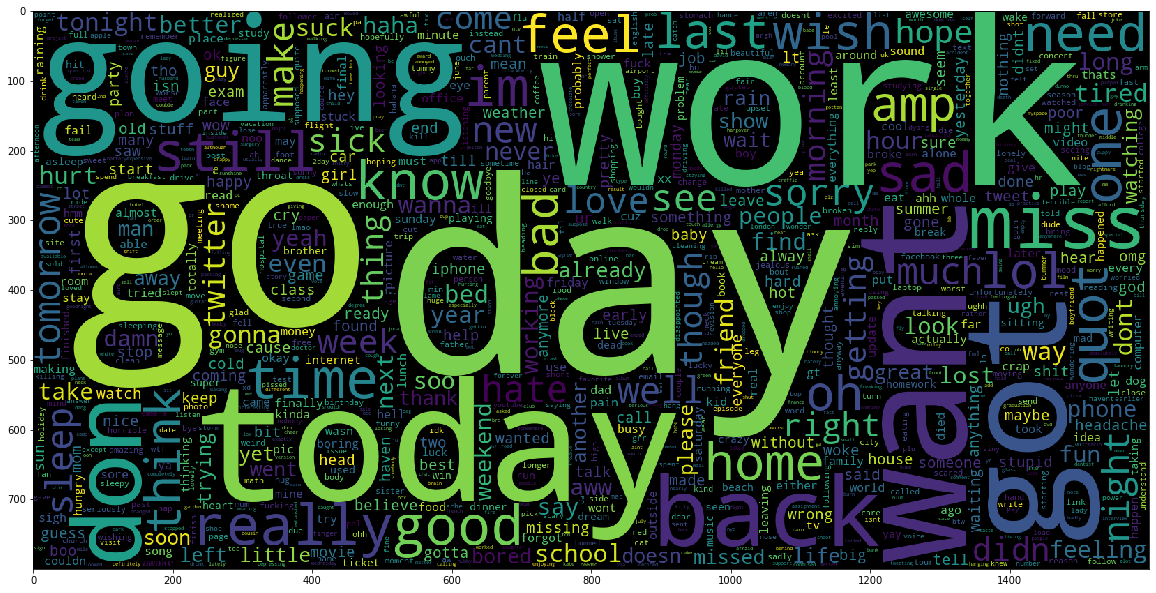

In [31]:
#Word Cloud for Negative tweets 

data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

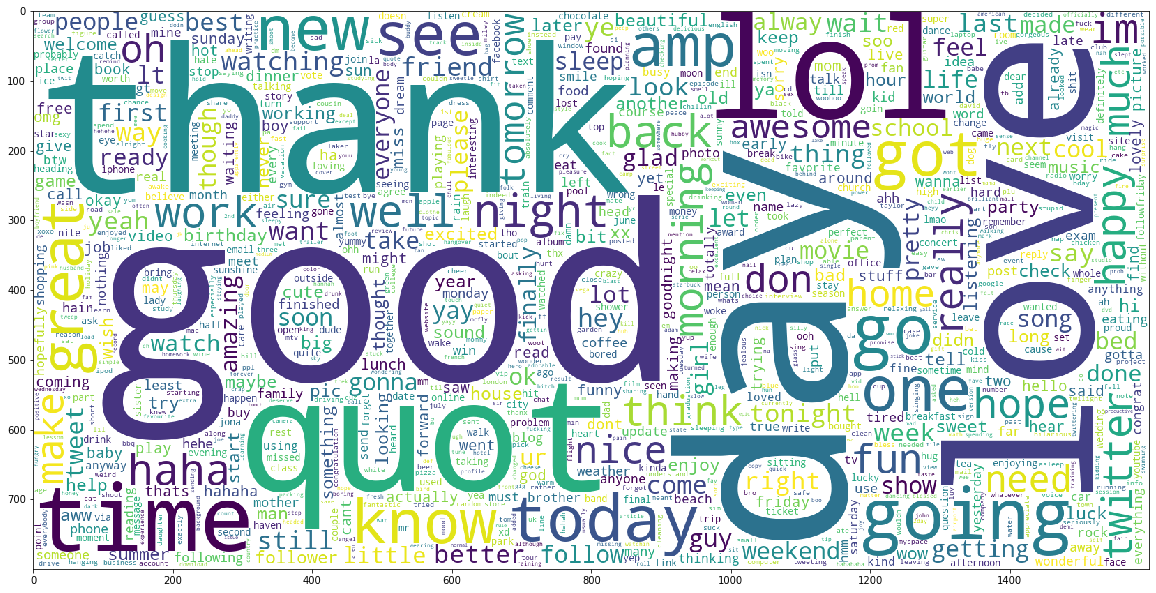

In [32]:
#Word Cloud for Positive tweets 

data_pos = processedtext[800000:]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False,background_color='white').generate(" ".join(data_pos))
plt.imshow(wc)

In [51]:
#SPLITTING DATA TO TRAINING AND TEST SETS 
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)

In [39]:
from keras.preprocessing.text import Tokenizer
X_train = Tokenizer.texts_to_sequences(X_train)
X_test = Tokenizer.texts_to_sequences(X_test)

TypeError: texts_to_sequences() missing 1 required positional argument: 'texts'

In [ ]:
#TOPIC MODELING 

In [38]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

In [45]:
#NMF Modeling
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(CleanDataFrame['text1'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
#doc_term_matrix_tfidf

In [42]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                          for i in topic.argsort()[:-no_top_words - 1:-1]]))
no_top_words = 10

In [46]:
nmf = NMF(n_components=10, random_state=0, alpha=.1, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
user yeah haha hope aww hey follow nice awesome cool
Topic 1:
good morning night luck feel hope sound thing lost feeling
Topic 2:
work tomorrow ready hour tired weekend week tonight wanna sleep
Topic 3:
url check cute pic add photo follower video gt amp
Topic 4:
quot song amp watching movie thing haha people tweet friend
Topic 5:
day happy great mother tomorrow school hope nice long beautiful
Topic 6:
love song haha guy amp friend watching movie life happy
Topic 7:
lol haha yeah twitter dont aww feel amp fun bad
Topic 8:
today feel feeling sick school sad hope fun bad gonna
Topic 9:
time night sleep twitter bed great fun tomorrow tonight long


In [50]:
CleanDataFrame.head()

,sentiment1,text1,tokenized,nmf_topics
0,0,USER URL aww bummer shoulda david carr day,"[USER, URL, aww, bummer, shoulda, david, carr,...",Sharing media files
1,0,upset update facebook texting result school to...,"[upset, update, facebook, texting, result, sch...",Missing school while sick
2,0,USER dived time ball managed save 50 rest bound,"[USER, dived, time, ball, managed, save, 50, r...",Night greeting
3,0,body feel itchy,"[body, feel, itchy]",Missing school while sick
4,0,USER behaving mad,"[USER, behaving, mad]",Feel good


In [52]:
nmf_topic_values = nmf.transform(tfidf)
CleanDataFrame['nmf_topics'] = nmf_topic_values.argmax(axis=1)
#lda_topic_values = lda_model.transform(tf)
#df['lda_topics'] = lda_topic_values.argmax(axis=1)
#lda_remap = {0: 'Good Design Processes', 1: 'Great Work Environment', 2: 'Flexible Work Hours', 3: 'Skill Building', 4: 'Difficult but Enjoyable Work', 5: 'Great Company/Job', 6: 'Care about Employees', 7: 'Great Contractor Pay', 8: 'Customer Service', 9: 'Unknown1'}
#df['lda_topics'] = df['lda_topics'].map(lda_remap)
nmf_remap = {0: 'Feeling good', 1: 'Morning greeting', 2: 'Workweek struggle', 3: 'Sharing media files ', 
             4: 'Movie night', 5: 'Mother’s day greeting', 6: 'Happy romance ', 7: 'Emotions', 
             8: 'Missing school while sick', 9: 'Night greeting'}
CleanDataFrame['nmf_topics'] = CleanDataFrame['nmf_topics'].map(nmf_remap)

(array([     0., 100000., 200000., 300000., 400000., 500000., 600000.]),
 <a list of 7 Text xticklabel objects>)

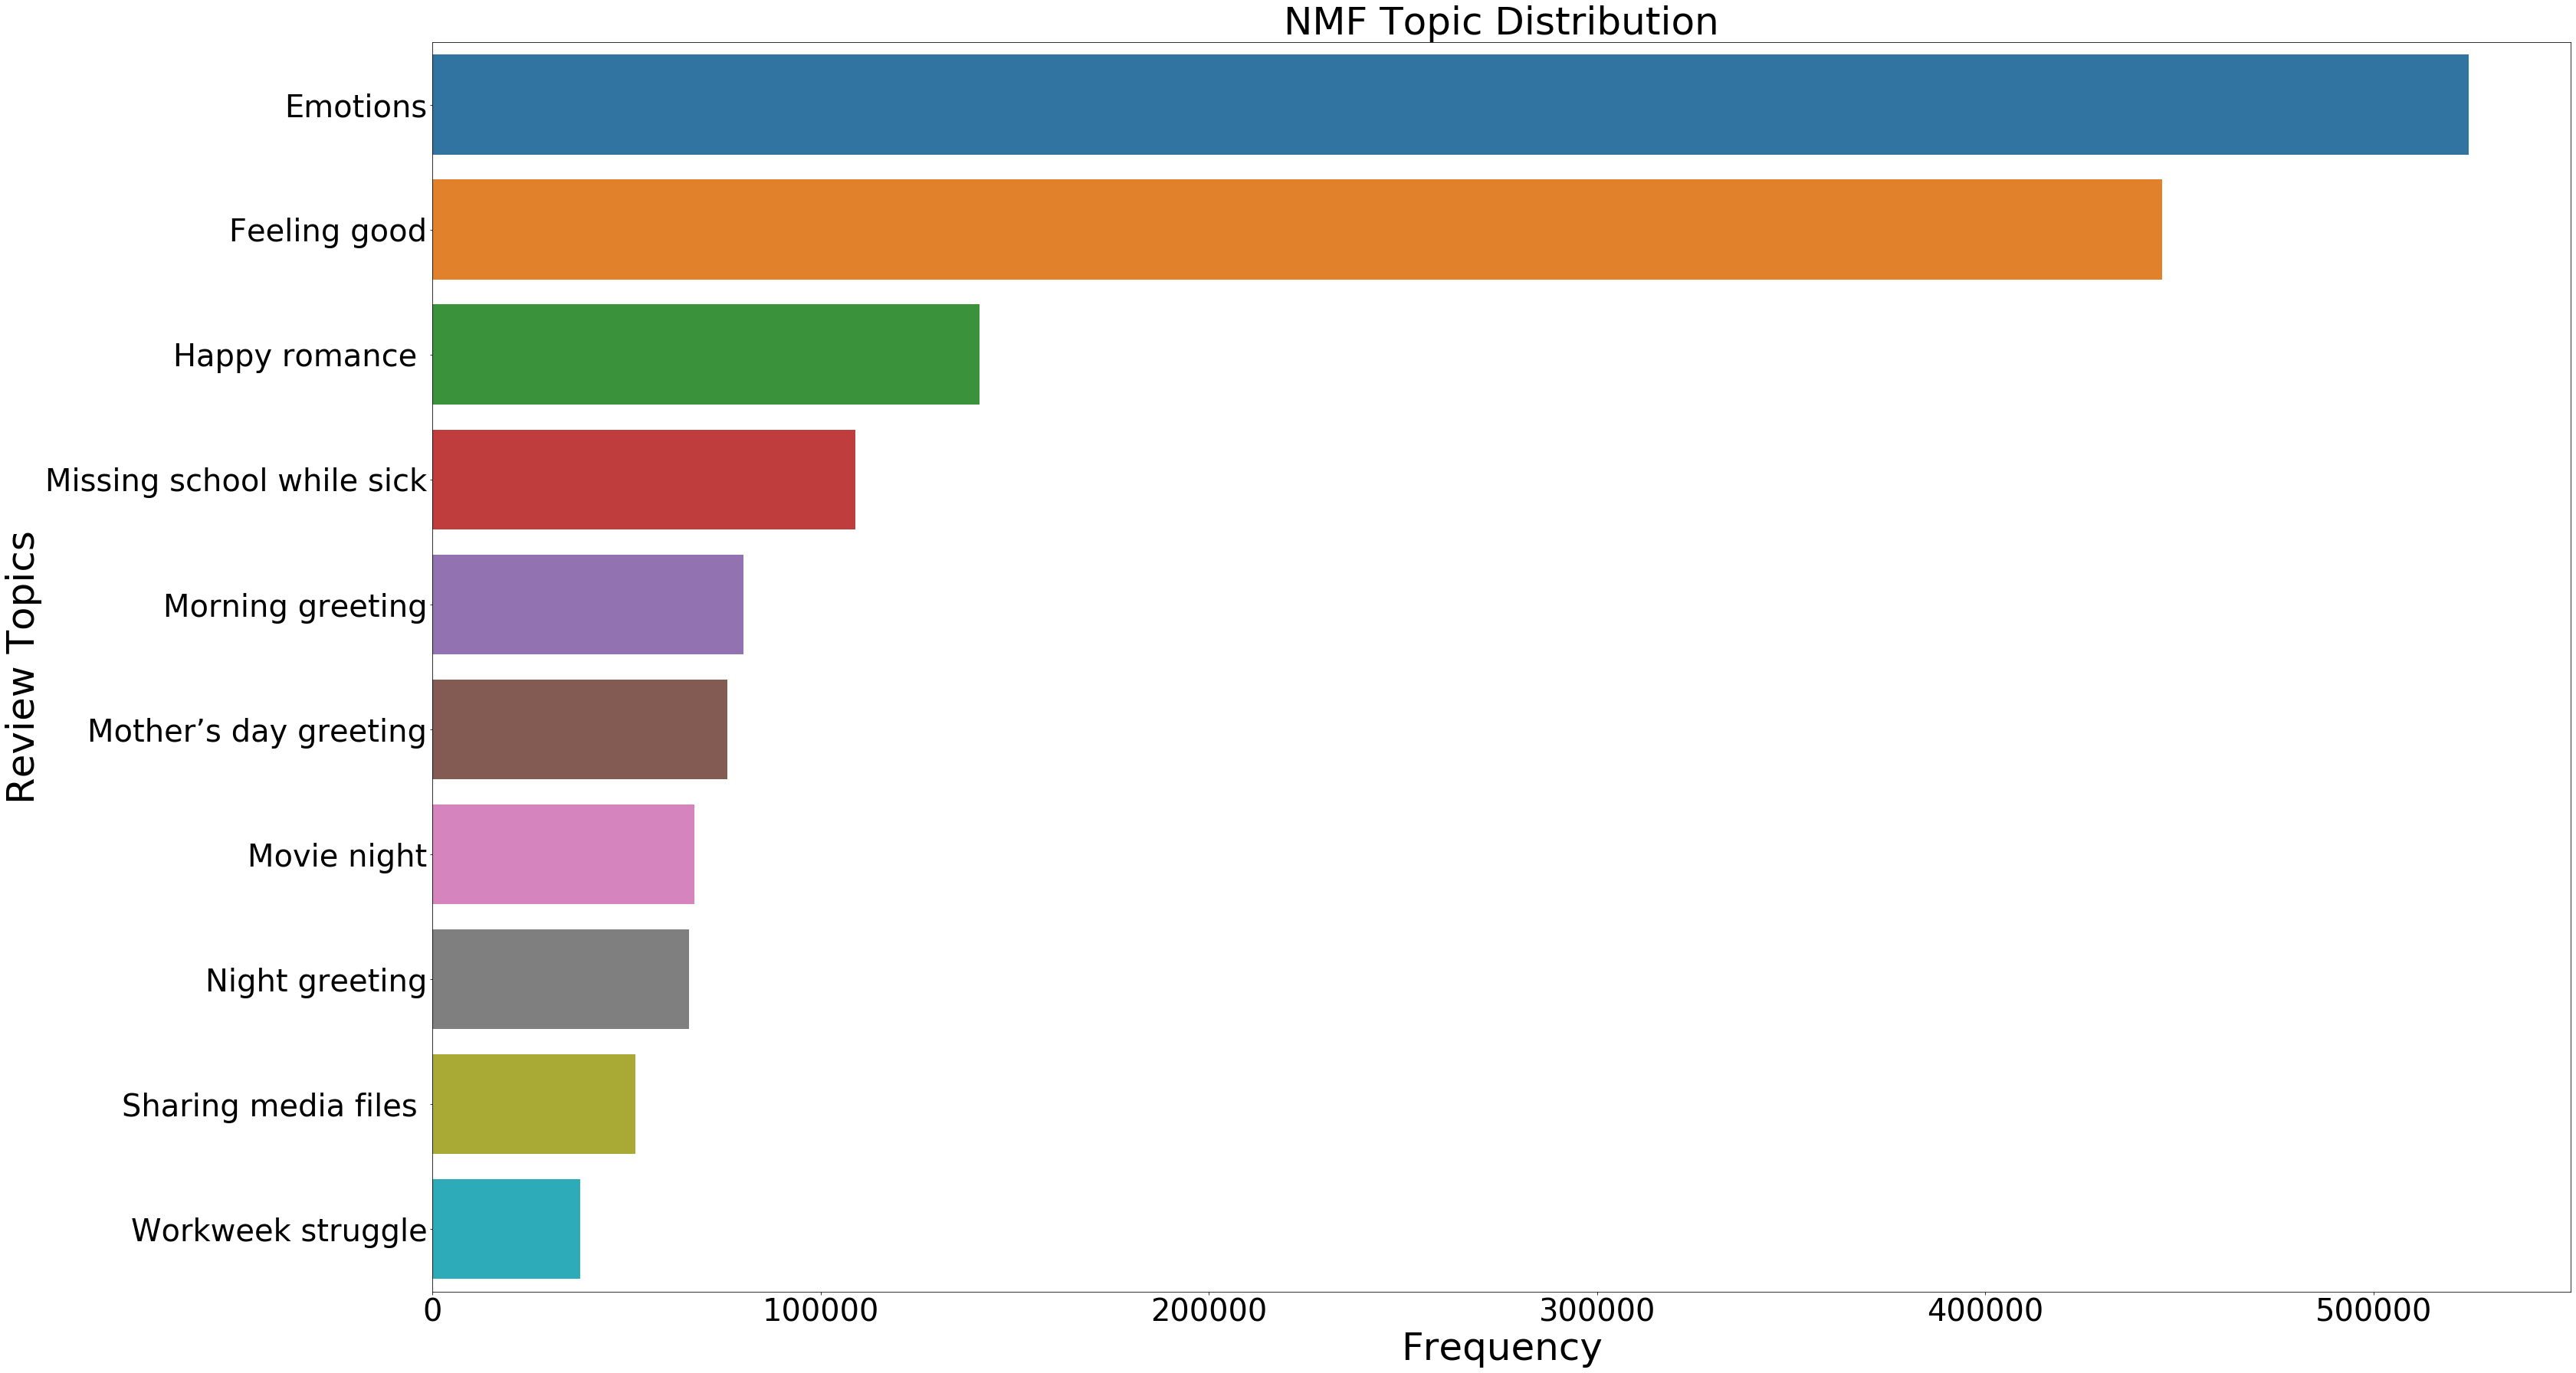

In [53]:
#Distribution of topics across all sentiments
nmf_x = CleanDataFrame['nmf_topics'].value_counts()
nmf_y = nmf_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_x, nmf_y.index)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.]),
 <a list of 7 Text xticklabel objects>)

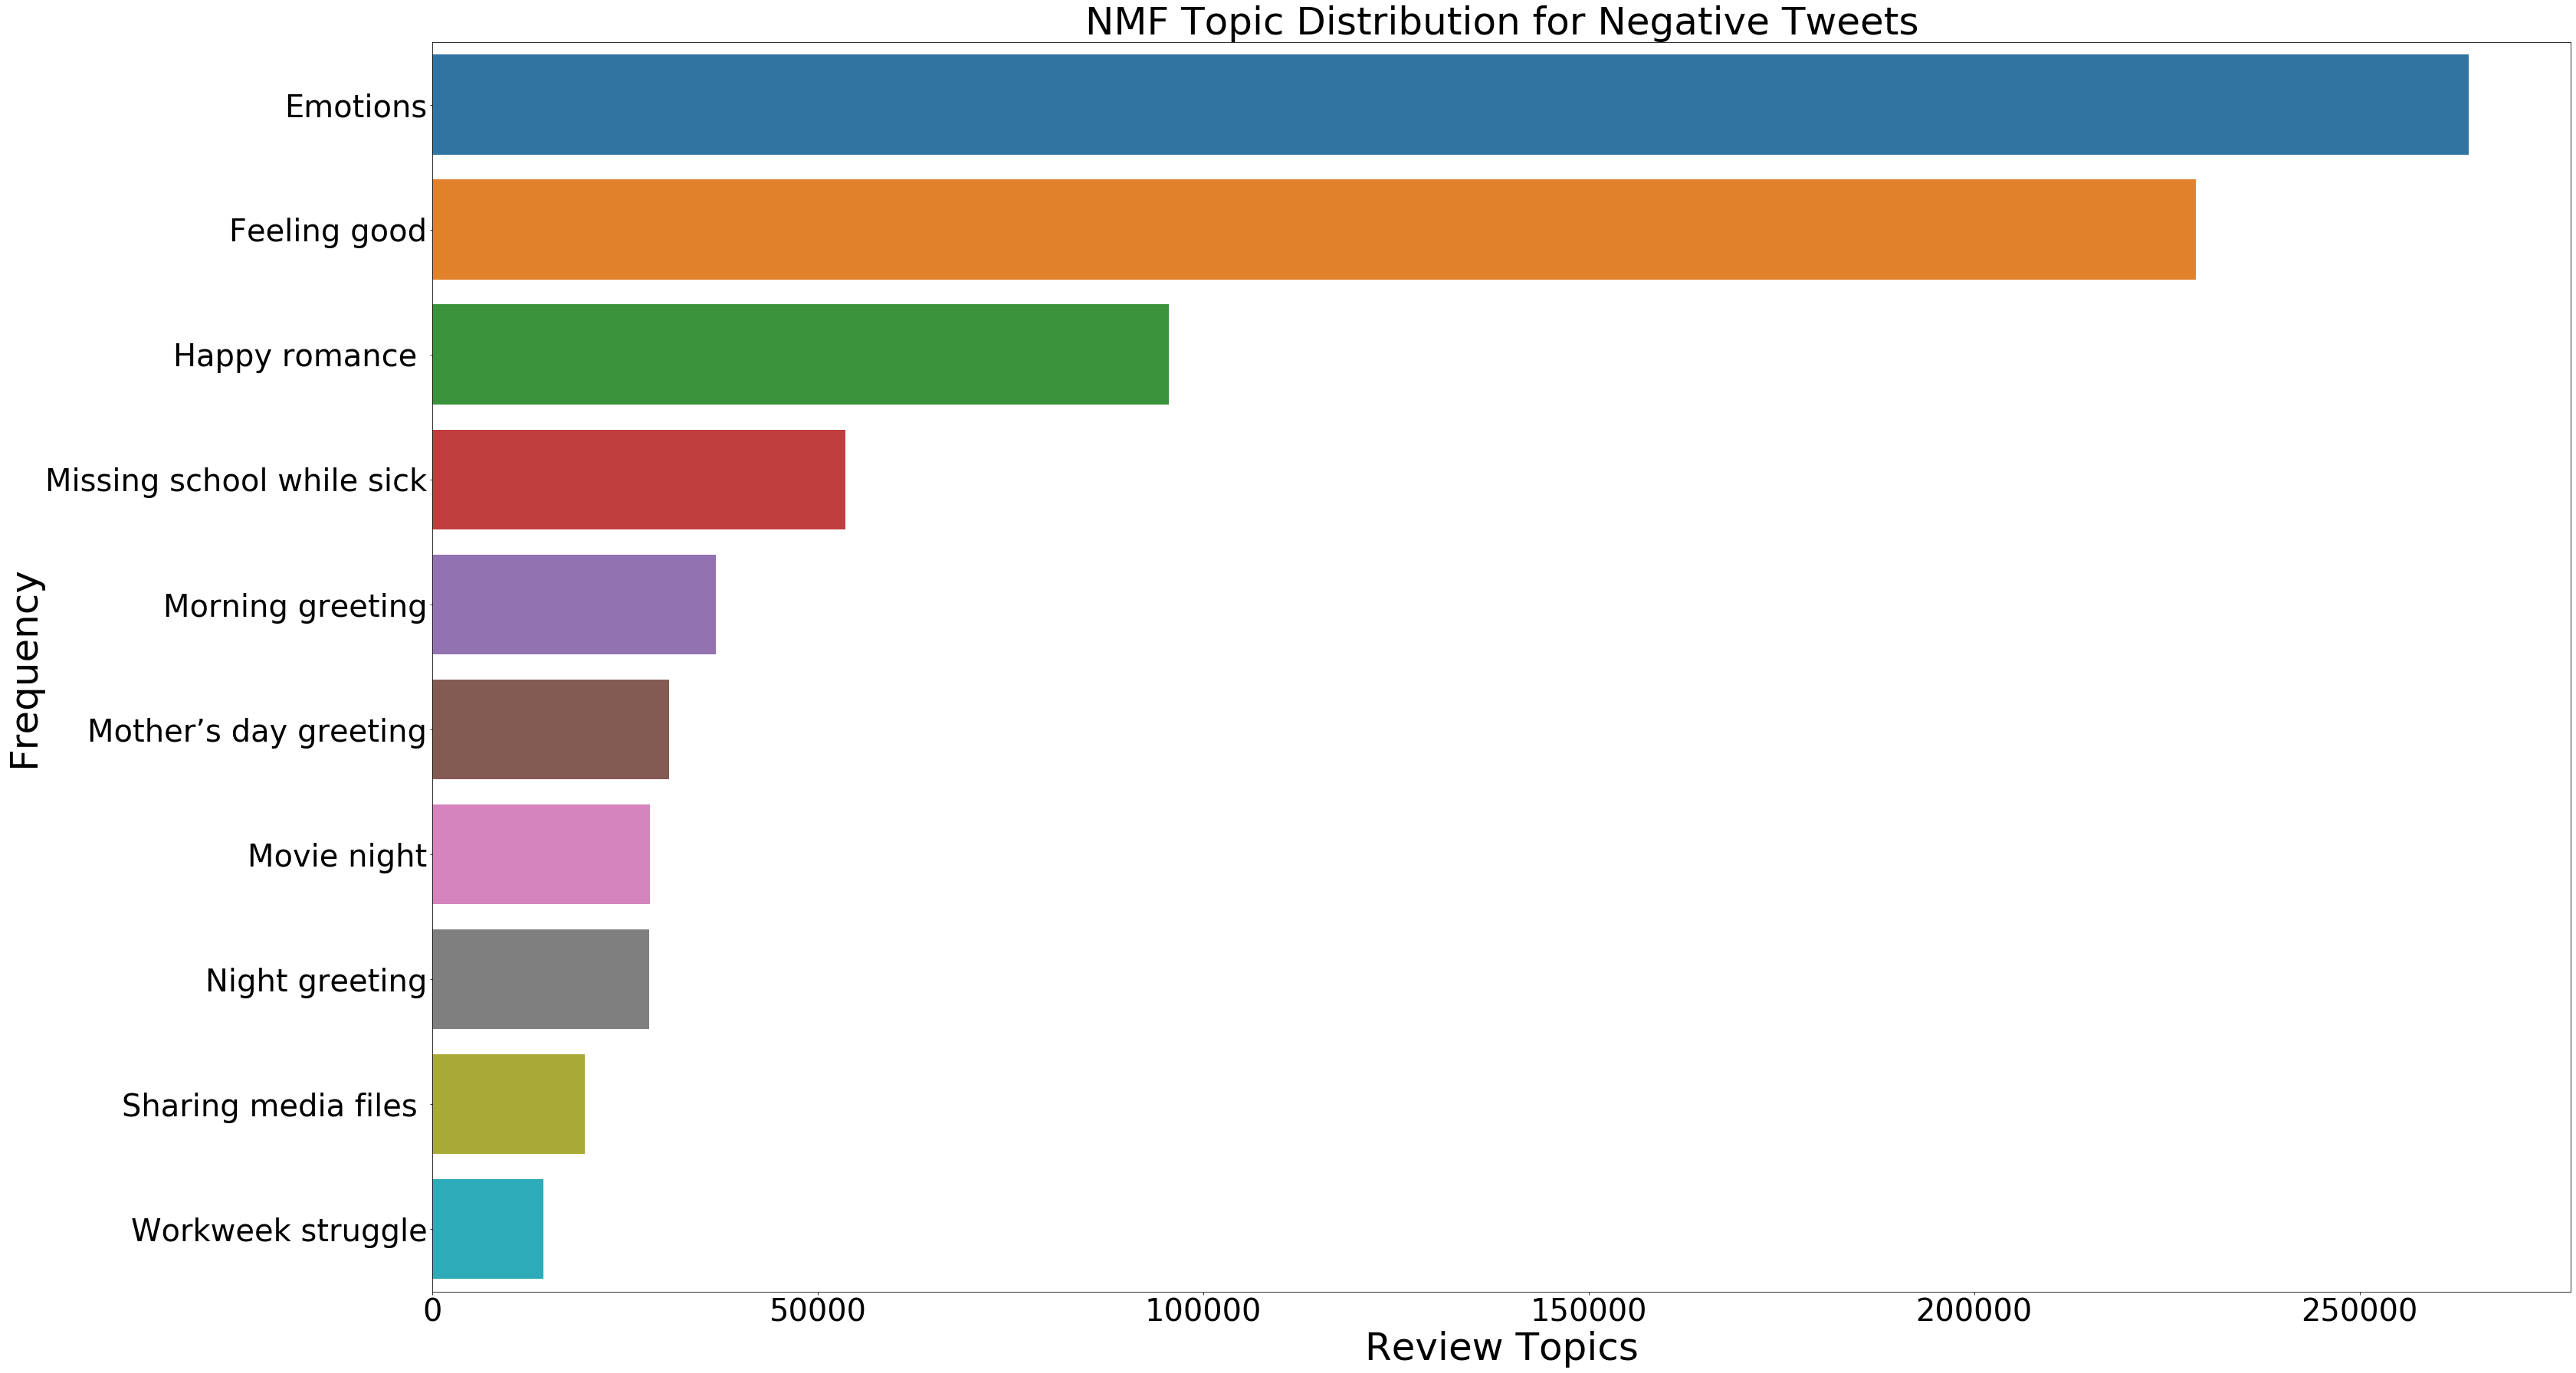

In [57]:
#Distribution of topics across NEGATIVE sentiments
df_low_ratings = CleanDataFrame.loc[(CleanDataFrame['sentiment1']==0)]
nmf_low_x = df_low_ratings['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Negative Tweets", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

(array([     0.,  50000., 100000., 150000., 200000., 250000., 300000.,
        350000.]),
 <a list of 8 Text xticklabel objects>)

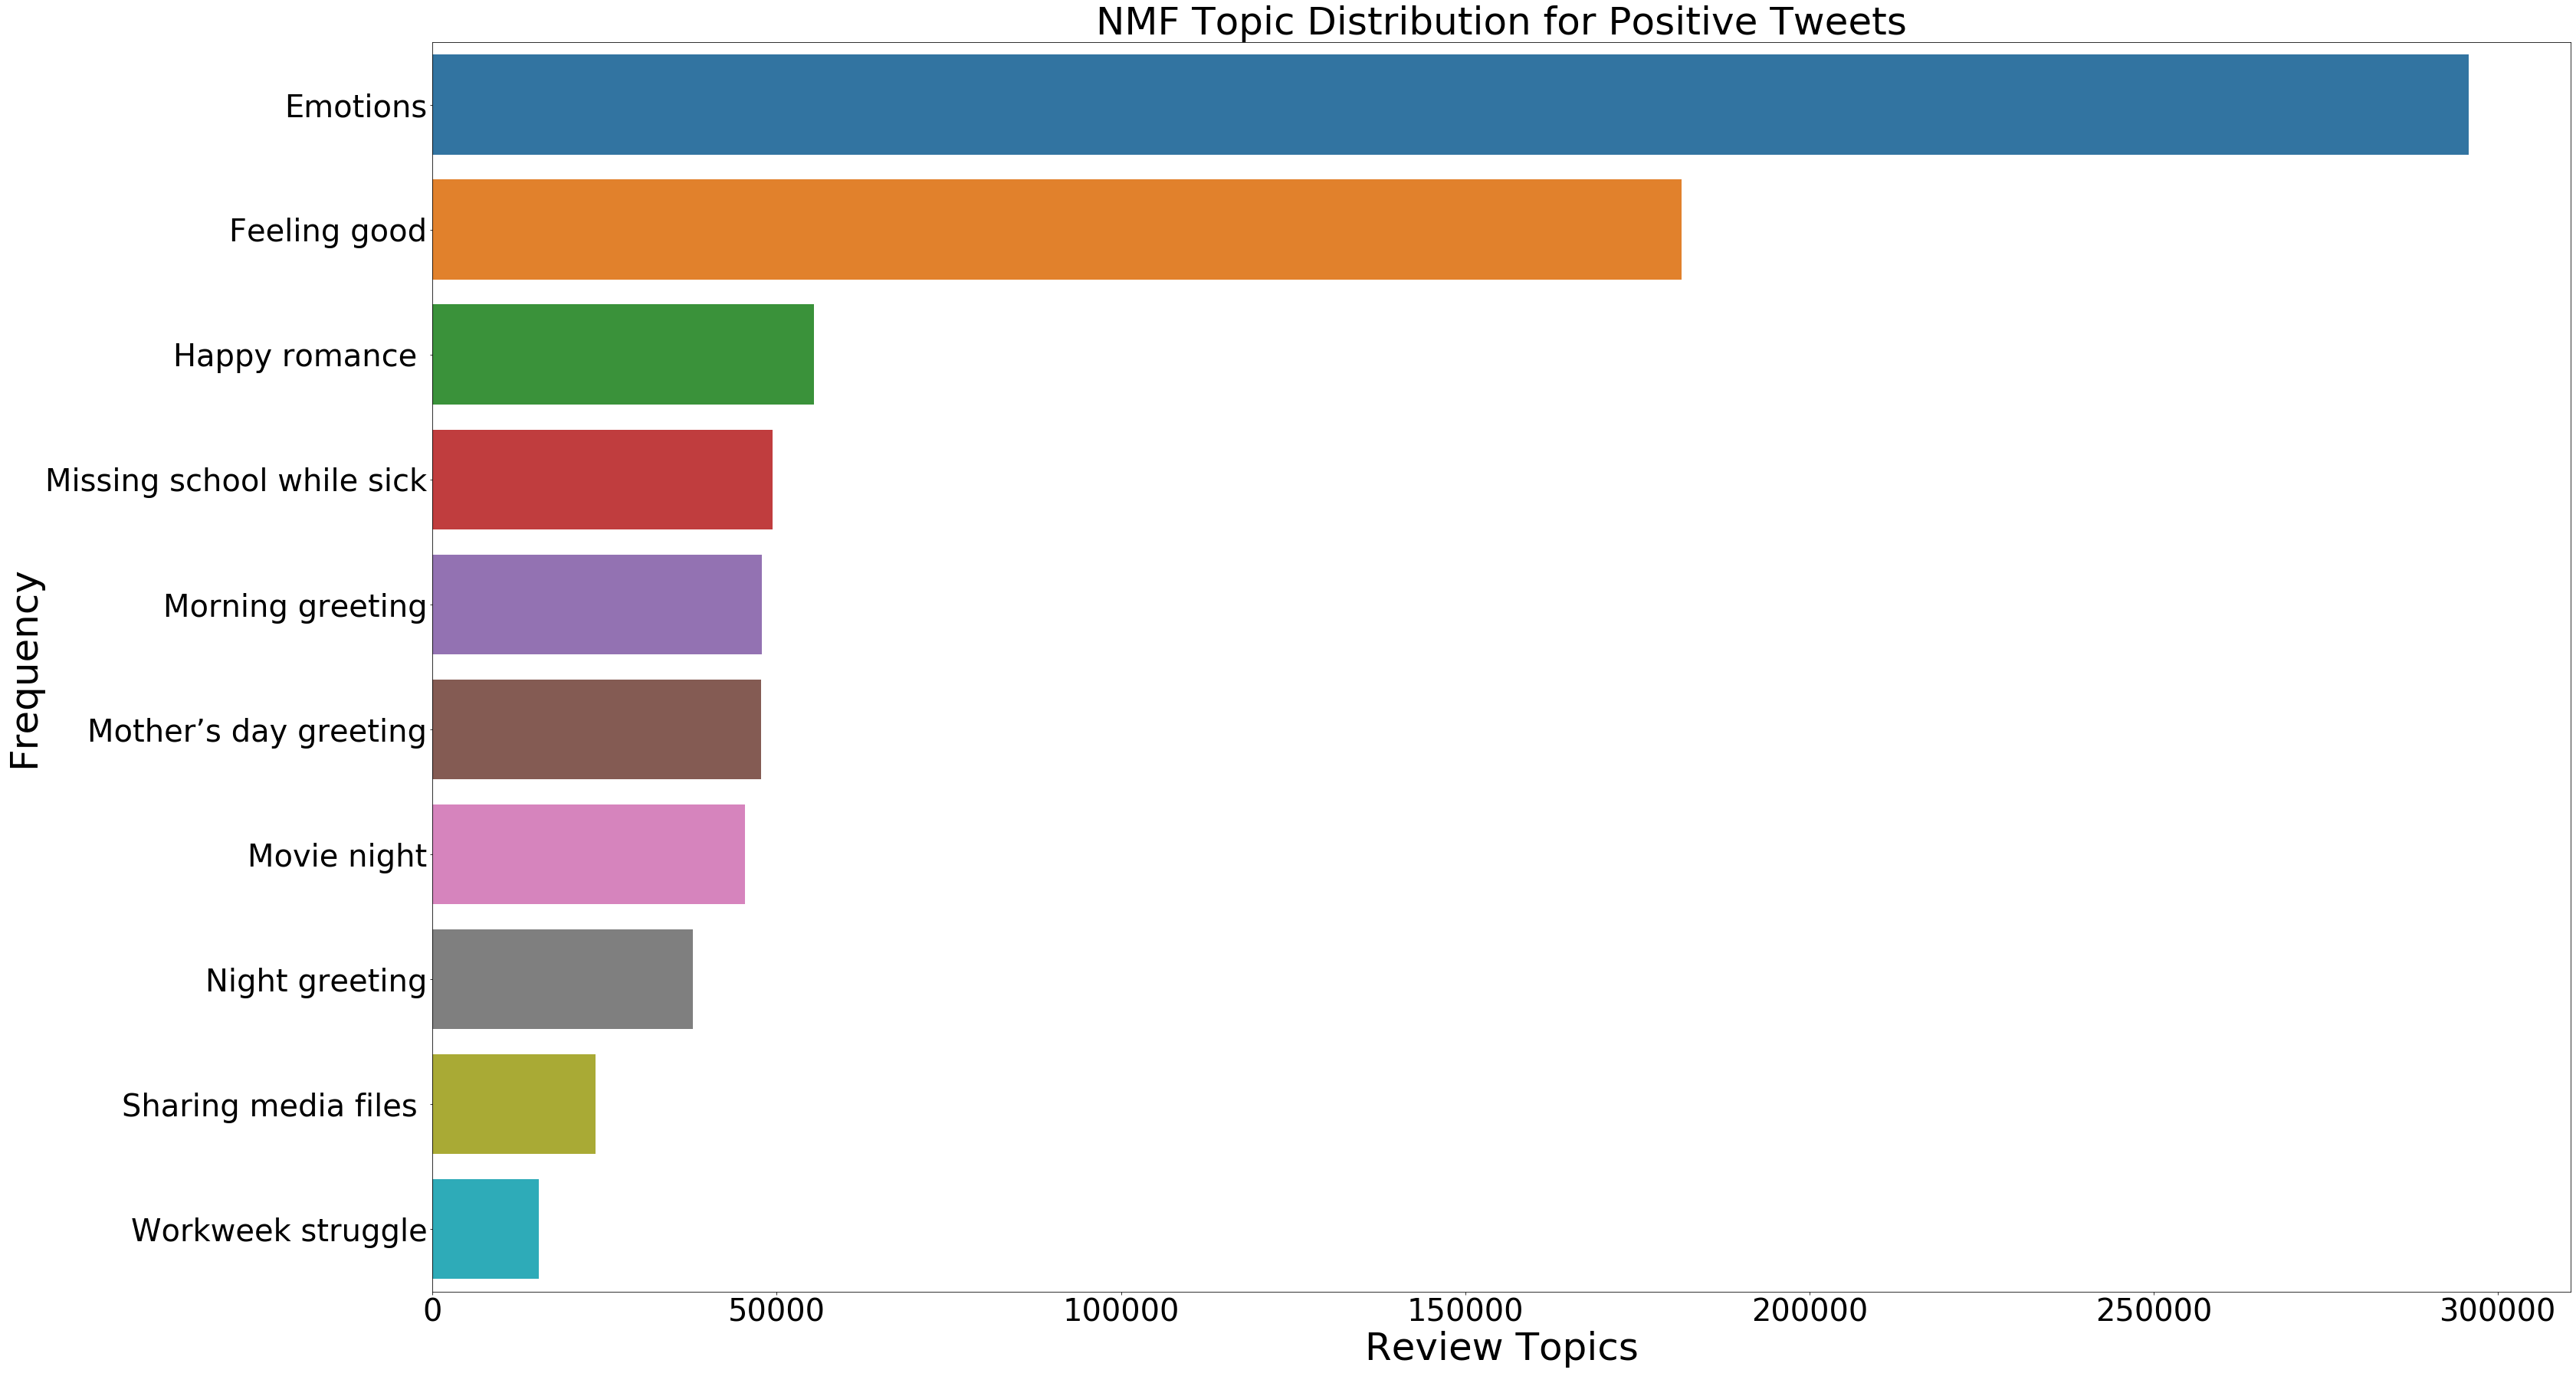

In [59]:
#Distribution of topics across POSITIVE sentiments
df_low_ratings = CleanDataFrame.loc[(CleanDataFrame['sentiment1']==1)]
nmf_low_x = df_low_ratings['nmf_topics'].value_counts()
nmf_low_y = nmf_low_x.sort_index()
plt.figure(figsize=(50,30))
sns.barplot(nmf_low_x, nmf_low_y.index)
plt.title("NMF Topic Distribution for Positive Tweets", fontsize=50)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Review Topics', fontsize=50)
plt.xticks(fontsize=40)

In [40]:
#LDA Modeling
from sklearn.feature_extraction.text import CountVectorizer

In [41]:
tf_vectorizer = CountVectorizer(max_df=0.9, min_df=25, max_features=5000)
tf = tf_vectorizer.fit_transform(CleanDataFrame['text1'].values.astype('U'))
tf_feature_names = tf_vectorizer.get_feature_names()

In [ ]:
#Technical difficulties, the alforithm did not finilize due to computational capacity 
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=500, random_state=0).fit(tf)
no_top_words = 10
              
display_topics(lda_model, tf_feature_names, no_top_words)

In [41]:
#APPLYING TF-IDF VECTORIZER 
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [42]:
#TRANSFORMING THE DATASET
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


In [43]:
#EVALUATION FUNCTION to visualize the results of algorithms 

def model_Evaluate(model):    
    # Predicting values using test dataset
    y_pred = model.predict(X_test)

    # Printing the matrics
    print(classification_report(y_test, y_pred))
    
    # Plotting Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.76      0.78     39989
           1       0.77      0.82      0.80     40011

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



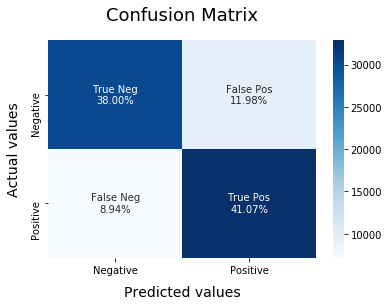

In [44]:
#NAIVE BAYES 
BNBmodel = BernoulliNB(alpha = 1)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

In [24]:
#LOGISTIC REGRESSION

C:\Users\nbuna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       0.82      0.80      0.81     39989
           1       0.81      0.82      0.82     40011

    accuracy                           0.81     80000
   macro avg       0.81      0.81      0.81     80000
weighted avg       0.81      0.81      0.81     80000



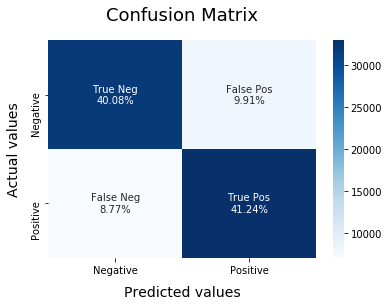

In [45]:
from sklearn.linear_model import LogisticRegression
Logistic_Regression = LogisticRegression(class_weight="balanced", random_state=0).fit(X_train, y_train)
model_Evaluate(Logistic_Regression)

In [80]:
#NEURAL NETWORK


In [46]:
from keras.preprocessing.text import Tokenizer

In [47]:
from keras.preprocessing.sequence import pad_sequences

In [48]:
from keras.models import Sequential

In [49]:
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.layers.core import Activation, Dropout, Dense

In [52]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [53]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [54]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(r'C:\Users\nbuna\Downloads\glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [55]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [56]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          24120100  
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 24,130,101
Trainable params: 10,001
Non-trainable params: 24,120,100
_________________________________________________________________
None


In [58]:
X_train=np.array(X_train)
y_train=np.array(y_train)

In [59]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
9500/9500 [==============================] - 77s 8ms/step - loss: 0.5782 - acc: 0.7025 - val_loss: 0.5744 - val_acc: 0.7067
Epoch 2/6
9500/9500 [==============================] - 81s 9ms/step - loss: 0.5745 - acc: 0.7058 - val_loss: 0.5749 - val_acc: 0.7049
Epoch 3/6
9500/9500 [==============================] - 82s 9ms/step - loss: 0.5743 - acc: 0.7061 - val_loss: 0.5747 - val_acc: 0.7055
Epoch 4/6
9500/9500 [==============================] - 84s 9ms/step - loss: 0.5743 - acc: 0.7063 - val_loss: 0.5746 - val_acc: 0.7062
Epoch 5/6
9500/9500 [==============================] - 78s 8ms/step - loss: 0.5742 - acc: 0.7063 - val_loss: 0.5746 - val_acc: 0.7049
Epoch 6/6
9500/9500 [==============================] - 78s 8ms/step - loss: 0.5742 - acc: 0.7063 - val_loss: 0.5746 - val_acc: 0.7072


In [60]:
X_test=np.array(X_test)
y_test=np.array(y_test)
score = model.evaluate(X_test, y_test, verbose=1)

2500/2500 [==============================] - 8s 3ms/step - loss: 0.5751 - acc: 0.7065


In [61]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5750889182090759
Test Accuracy: 0.7065374851226807
